* *DATA CLEANING*
* *DATA IMPUTATION (NaN imputation, Zeros imputation)*
* *FEATURE SELECTION (RFE)*
* **NO GRID SEARCH**

In [1]:
!pip install lazypredict-nightly

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and pla

In [2]:
!pip install missingno

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [4]:
import time
import pickle
import missingno as msno
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [5]:
import lazypredict
from lazypredict import LazyRegressor

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import (
    LinearRegression, Lars, LassoLarsIC, Lasso, ElasticNet, LassoCV, LarsCV,
    LassoLarsCV, ElasticNetCV, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor,
    Ridge, RidgeCV, SGDRegressor, TweedieRegressor, GammaRegressor, PoissonRegressor
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor,
    ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
)
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## Preprocessing and feature engineering of the collected data

In [7]:
# Load data
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv

--2025-02-09 10:53:44--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338231 (330K) [text/plain]
Saving to: ‘docking_scores_data.csv’

docking_scores_data 100%[===================>] 330.30K  --.-KB/s    in 0.02s   

2025-02-09 10:53:45 (17.3 MB/s) - ‘docking_scores_data.csv’ saved [338231/338231]

--2025-02-09 10:53:45--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [8]:
df = pd.read_csv("docking_scores_data.csv")
df.columns

Index(['smiles', 'Delta_Gibbs'], dtype='object')

In [9]:
# Handling missing data && cleaning
df = df.dropna(subset=['Delta_Gibbs'])
df = df.drop_duplicates(['smiles']).reset_index(drop=True)
df.shape

(8515, 2)

In [10]:
# Load RDKit descriptors
RDKit_df = pd.read_csv("RDKit_descriptors.csv")
RDKit_df.shape

(8515, 210)

In [11]:
# Load PaDEL descriptors
PaDEL_df = pd.read_csv("PaDEL_descriptors.csv")
PaDEL_df.shape

(8515, 1444)

### Exploratory Data Analysis (EDA)

**Frequency plot of Delta Gibbs**

Text(0, 0.5, 'Frequency')

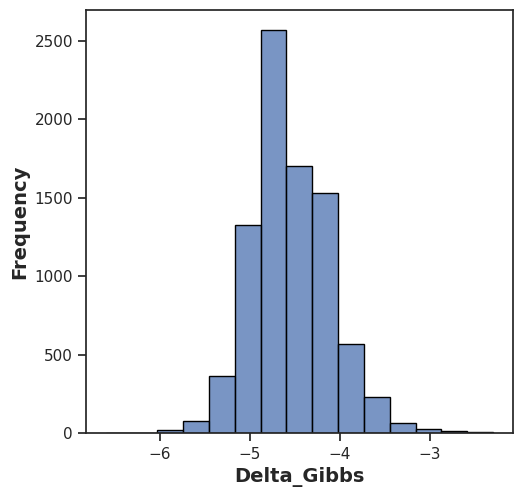

In [12]:
plt.figure(figsize=(5.5, 5.5))

sns.histplot(x='Delta_Gibbs', data=df, bins=15, edgecolor='black')

plt.xlabel('Delta_Gibbs', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# plt.savefig('plot_bioactivity_class.pdf')

**Delta Gibbs Box plot**


Text(0, 0.5, 'Delta_Gibbs')

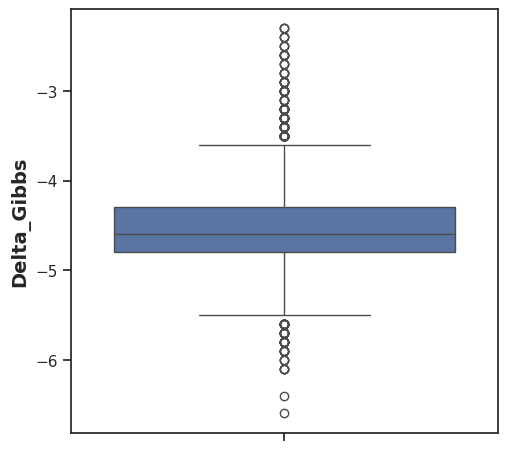

In [13]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(y='Delta_Gibbs', data=df)

plt.ylabel('Delta_Gibbs', fontsize=14, fontweight='bold')

**Descriptors Box Plot**

<Axes: >

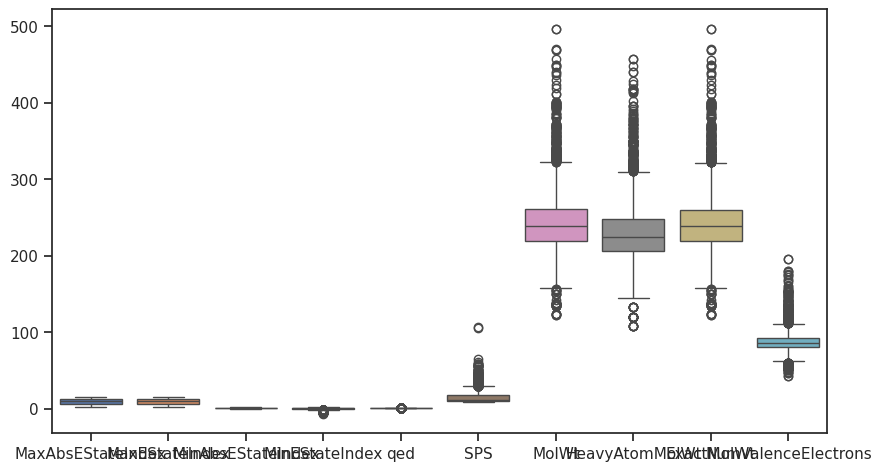

In [14]:
# RDKit
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=RDKit_df.iloc[:,:10])

<Axes: >

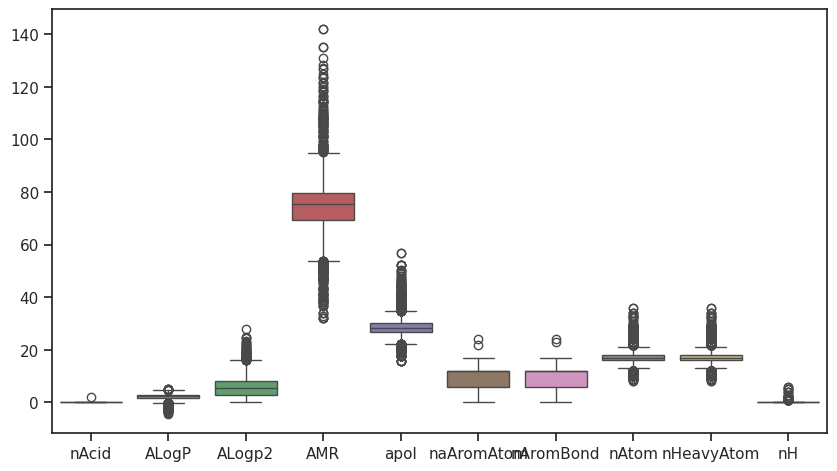

In [15]:
# PaDEL
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=PaDEL_df.iloc[:,:10])

**NaN Visualization**

<Axes: >

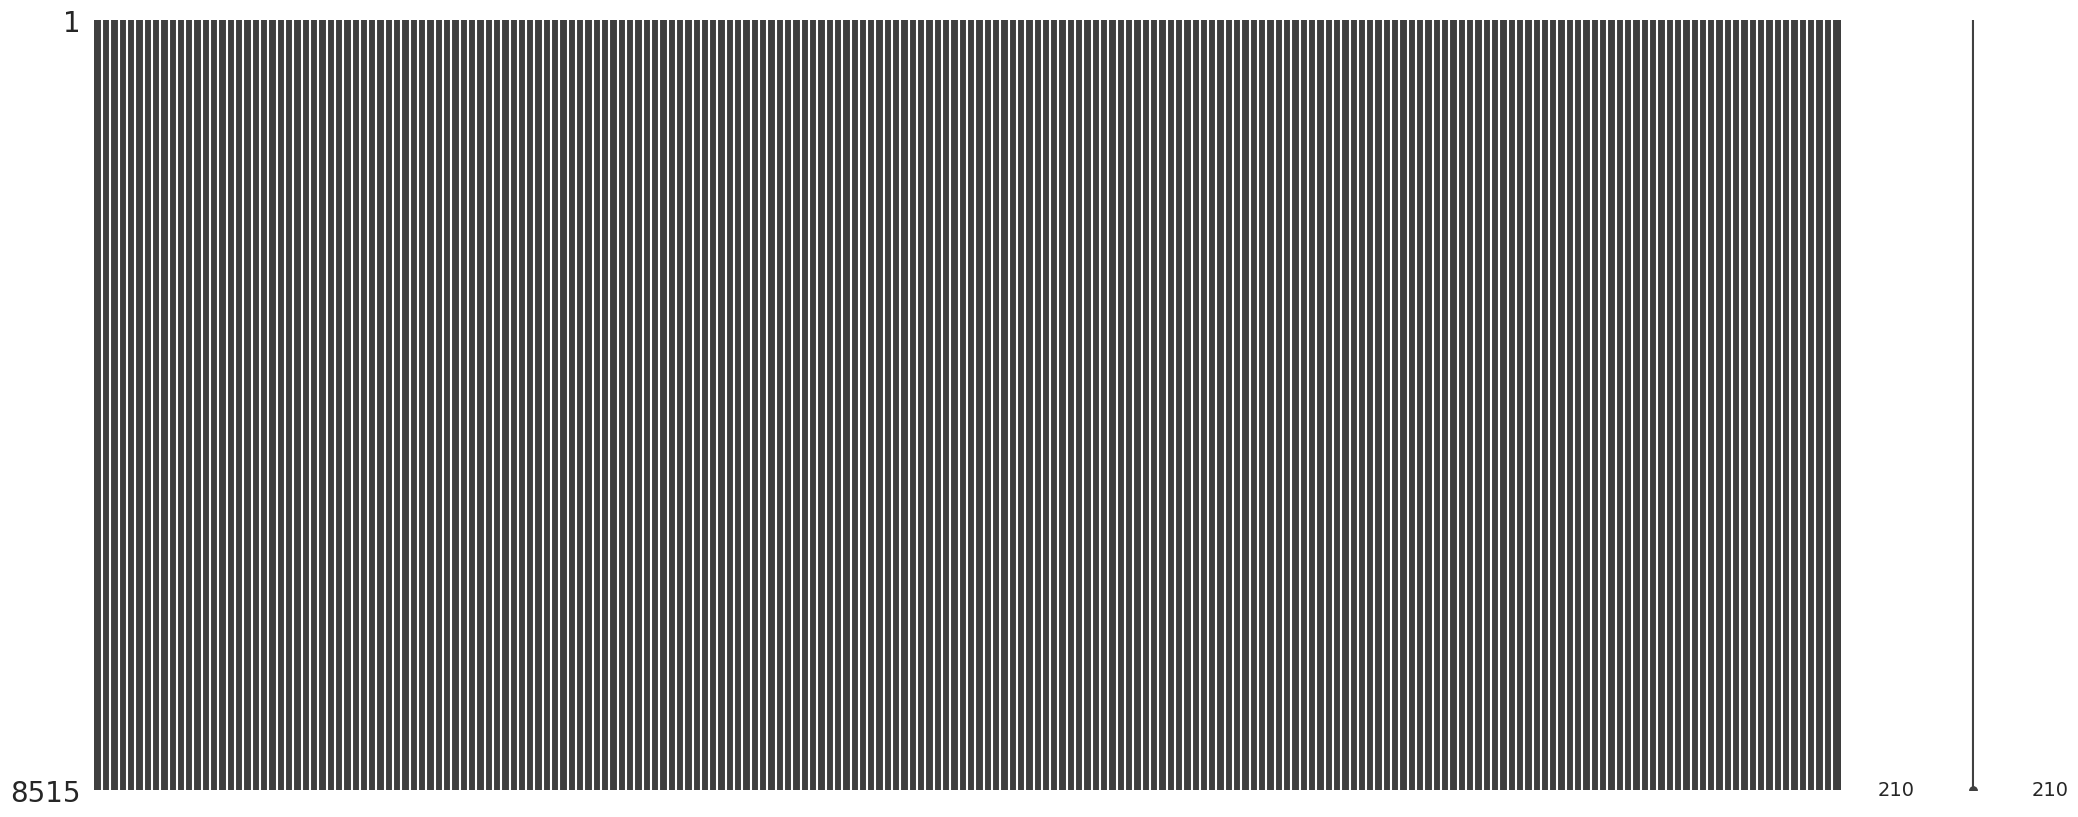

In [16]:
# RDKit
msno.matrix(RDKit_df)

<Axes: >

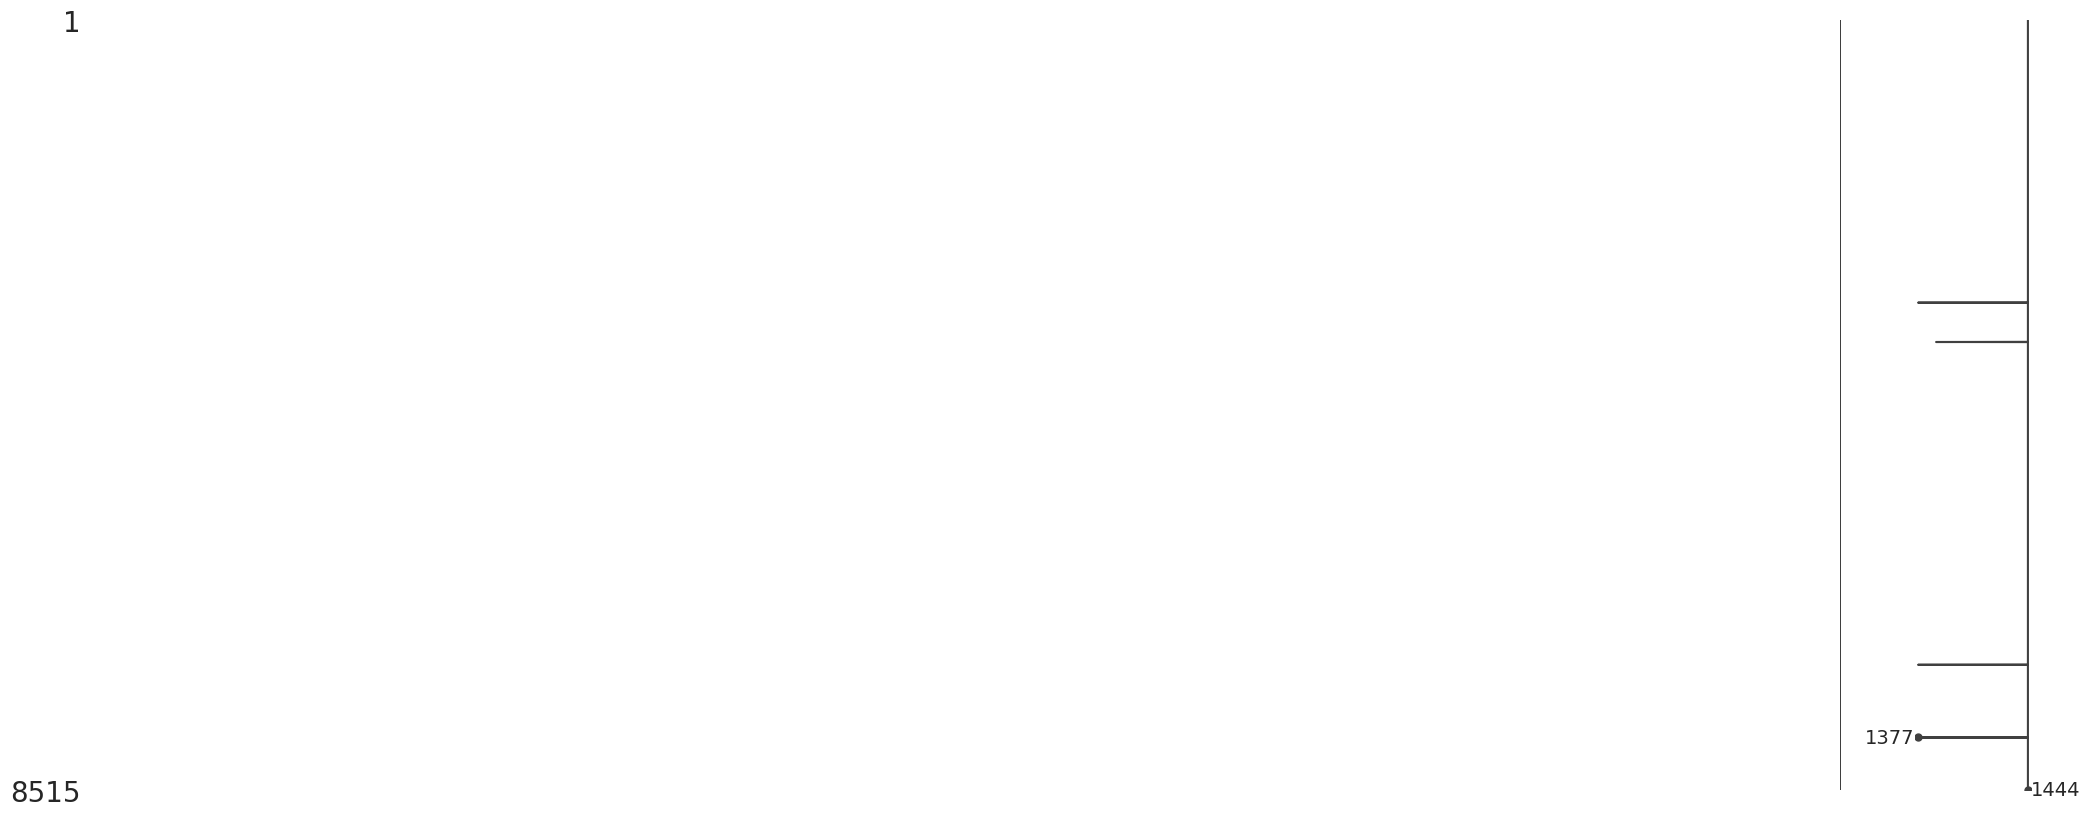

In [17]:
# PaDEL
msno.matrix(PaDEL_df)

### Data Cleaning and Imputation

RDKit

In [18]:
RDKit_df.shape

(8515, 210)

In [19]:
# Drop columns with 90% NaN
RDKit_df = RDKit_df.loc[:, RDKit_df.isna().mean(axis=0) < 0.9]
RDKit_df.shape

(8515, 210)

In [20]:
# fill NaN values with the median of each column
RDKit_df.fillna(RDKit_df.median(), inplace=True)
RDKit_df.shape

(8515, 210)

In [21]:
# Drop columns with 90% zeros
RDKit_df = RDKit_df.loc[:, (RDKit_df == 0).mean(axis=0) < 0.9]
RDKit_df.shape

(8515, 129)

PaDEL

In [22]:
PaDEL_df.shape

(8515, 1444)

In [23]:
# Drop columns with 90% NaN
PaDEL_df = PaDEL_df.loc[:, PaDEL_df.isna().mean(axis=0) < 0.9]
PaDEL_df.shape

(8515, 1444)

In [24]:
# fill NaN values with the median of each column
PaDEL_df.fillna(PaDEL_df.median(), inplace=True)
PaDEL_df.shape

(8515, 1444)

In [25]:
# Drop columns with 90% zeros
PaDEL_df = PaDEL_df.loc[:, (PaDEL_df == 0).mean(axis=0) < 0.9]
PaDEL_df.shape

(8515, 928)

### Data Transformation

In [26]:
# Initialization of data scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [27]:
# Scale data
RDKit_scaled = robust_scaler.fit_transform(RDKit_df)
RDKit_scaled = minmax_scaler.fit_transform(RDKit_scaled)
PaDEL_scaled = robust_scaler.fit_transform(PaDEL_df)
PaDEL_scaled = minmax_scaler.fit_transform(PaDEL_scaled)

In [28]:
# Create RDKit scaled DataFrame
RDKit_columns = RDKit_df.columns
RDKit_scaled_df = pd.DataFrame(RDKit_scaled)
RDKit_scaled_df.columns = RDKit_columns
RDKit_scaled_df.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_NH0,fr_allylic_oxid,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_para_hydroxylation,fr_sulfide
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.50,0.50,0.32,0.81,0.66,0.07,0.32,0.35,0.32,0.28,...,0.07,0.03,0.09,0.51,0.04,0.02,0.07,0.09,0.06,0.03
std,0.28,0.28,0.24,0.15,0.13,0.07,0.09,0.10,0.09,0.08,...,0.12,0.08,0.15,0.20,0.09,0.07,0.12,0.13,0.14,0.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.27,0.27,0.12,0.77,0.57,0.02,0.26,0.28,0.26,0.25,...,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.63,0.63,0.25,0.83,0.68,0.03,0.31,0.33,0.31,0.29,...,0.00,0.00,0.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.76,0.76,0.49,0.91,0.75,0.10,0.37,0.40,0.37,0.32,...,0.20,0.00,0.20,0.67,0.00,0.00,0.20,0.11,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [29]:
# Create PaDEL scaled DataFrame
PaDEL_columns = PaDEL_df.columns
PaDEL_scaled_df = pd.DataFrame(PaDEL_scaled)
PaDEL_scaled_df.columns = PaDEL_columns
PaDEL_scaled_df.describe()

,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nC,nN,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.67,0.20,0.38,0.31,0.42,0.42,0.31,0.31,0.45,0.06,...,0.20,0.32,0.31,0.27,0.09,0.06,0.12,0.26,0.45,0.28
std,0.11,0.13,0.08,0.08,0.14,0.14,0.08,0.08,0.08,0.09,...,0.08,0.08,0.07,0.17,0.10,0.10,0.06,0.09,0.10,0.09
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.61,0.10,0.34,0.27,0.25,0.25,0.29,0.29,0.40,0.00,...,0.15,0.29,0.27,0.12,0.00,0.00,0.09,0.21,0.39,0.22
50%,0.69,0.19,0.39,0.31,0.50,0.50,0.32,0.32,0.44,0.00,...,0.19,0.33,0.30,0.23,0.09,0.00,0.11,0.26,0.44,0.26
75%,0.74,0.29,0.43,0.35,0.50,0.50,0.36,0.36,0.48,0.14,...,0.23,0.37,0.34,0.36,0.12,0.14,0.14,0.31,0.51,0.32
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Merge descriptors dataframes with Delta Gibbs scores

In [30]:
RDKit = pd.concat([RDKit_scaled_df,df['Delta_Gibbs']], axis = 1)
RDKit

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_allylic_oxid,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_para_hydroxylation,fr_sulfide,Delta_Gibbs
0,0.77,0.77,0.28,0.40,0.82,0.07,0.41,0.44,0.41,0.38,...,0.00,0.00,0.67,0.12,0.00,0.00,0.00,0.00,0.00,-4.20
1,0.72,0.72,0.21,0.40,0.76,0.03,0.32,0.35,0.32,0.23,...,0.00,0.00,0.67,0.12,0.00,0.00,0.11,0.00,0.00,-4.20
2,0.76,0.76,0.24,0.39,0.89,0.03,0.42,0.44,0.42,0.39,...,0.00,0.00,0.67,0.12,0.00,0.00,0.00,0.00,0.00,-4.20
3,0.67,0.67,0.03,0.76,0.61,0.02,0.29,0.32,0.29,0.29,...,0.00,0.00,0.67,0.12,0.00,0.00,0.00,0.00,0.00,-4.50
4,0.76,0.76,0.13,0.37,0.95,0.06,0.41,0.45,0.41,0.36,...,0.00,0.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.59,0.01,0.82,0.96,0.04,0.48,0.51,0.48,0.47,...,0.00,0.00,0.67,0.12,0.00,0.60,0.00,0.00,0.00,-4.90
8511,0.57,0.57,0.11,0.84,0.88,0.02,0.44,0.46,0.44,0.44,...,0.00,0.00,0.67,0.00,0.00,0.60,0.00,0.33,0.00,-4.70
8512,0.63,0.63,0.01,0.82,0.76,0.03,0.48,0.51,0.48,0.47,...,0.00,0.00,0.67,0.25,0.00,0.60,0.00,0.00,0.00,-4.70
8513,0.62,0.62,0.03,0.82,0.70,0.04,0.40,0.43,0.40,0.39,...,0.00,0.00,0.67,0.25,0.00,0.40,0.00,0.00,0.00,-5.10


In [31]:
PaDEL = pd.concat([PaDEL_scaled_df,df['Delta_Gibbs']], axis = 1)
PaDEL

,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nC,nN,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Delta_Gibbs
0,0.48,0.00,0.46,0.38,0.42,0.46,0.39,0.39,0.44,0.29,...,0.40,0.27,0.54,0.18,0.29,0.14,0.45,0.22,0.42,-4.20
1,0.61,0.09,0.32,0.25,0.42,0.46,0.25,0.25,0.32,0.00,...,0.26,0.27,0.40,0.18,0.00,0.07,0.29,0.34,0.24,-4.20
2,0.50,0.01,0.48,0.38,0.42,0.46,0.39,0.39,0.44,0.29,...,0.40,0.20,0.53,0.18,0.29,0.14,0.45,0.24,0.38,-4.20
3,0.56,0.04,0.29,0.24,0.42,0.46,0.32,0.32,0.36,0.29,...,0.33,0.26,0.49,0.27,0.29,0.11,0.32,0.30,0.29,-4.50
4,0.39,0.01,0.40,0.35,0.42,0.46,0.39,0.39,0.40,0.29,...,0.41,0.34,0.63,0.28,0.29,0.13,0.48,0.14,0.43,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.44,0.00,0.53,0.44,0.50,0.50,0.50,0.50,0.56,0.00,...,0.53,0.36,0.51,0.51,0.00,0.24,0.50,0.35,0.49,-4.90
8511,0.53,0.02,0.54,0.42,0.50,0.50,0.46,0.46,0.56,0.00,...,0.48,0.26,0.41,0.41,0.00,0.23,0.40,0.41,0.39,-4.70
8512,0.46,0.00,0.53,0.44,0.50,0.50,0.50,0.50,0.56,0.00,...,0.53,0.34,0.52,0.52,0.00,0.21,0.63,0.38,0.50,-4.70
8513,0.51,0.02,0.47,0.38,0.50,0.50,0.43,0.43,0.52,0.00,...,0.45,0.37,0.41,0.41,0.00,0.16,0.53,0.36,0.43,-5.10


In [32]:
RDKit_PaDEL = pd.concat([RDKit_scaled_df,PaDEL_scaled_df,df['Delta_Gibbs']], axis = 1)
RDKit_PaDEL

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Delta_Gibbs
0,0.77,0.77,0.28,0.40,0.82,0.07,0.41,0.44,0.41,0.38,...,0.40,0.27,0.54,0.18,0.29,0.14,0.45,0.22,0.42,-4.20
1,0.72,0.72,0.21,0.40,0.76,0.03,0.32,0.35,0.32,0.23,...,0.26,0.27,0.40,0.18,0.00,0.07,0.29,0.34,0.24,-4.20
2,0.76,0.76,0.24,0.39,0.89,0.03,0.42,0.44,0.42,0.39,...,0.40,0.20,0.53,0.18,0.29,0.14,0.45,0.24,0.38,-4.20
3,0.67,0.67,0.03,0.76,0.61,0.02,0.29,0.32,0.29,0.29,...,0.33,0.26,0.49,0.27,0.29,0.11,0.32,0.30,0.29,-4.50
4,0.76,0.76,0.13,0.37,0.95,0.06,0.41,0.45,0.41,0.36,...,0.41,0.34,0.63,0.28,0.29,0.13,0.48,0.14,0.43,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.59,0.01,0.82,0.96,0.04,0.48,0.51,0.48,0.47,...,0.53,0.36,0.51,0.51,0.00,0.24,0.50,0.35,0.49,-4.90
8511,0.57,0.57,0.11,0.84,0.88,0.02,0.44,0.46,0.44,0.44,...,0.48,0.26,0.41,0.41,0.00,0.23,0.40,0.41,0.39,-4.70
8512,0.63,0.63,0.01,0.82,0.76,0.03,0.48,0.51,0.48,0.47,...,0.53,0.34,0.52,0.52,0.00,0.21,0.63,0.38,0.50,-4.70
8513,0.62,0.62,0.03,0.82,0.70,0.04,0.40,0.43,0.40,0.39,...,0.45,0.37,0.41,0.41,0.00,0.16,0.53,0.36,0.43,-5.10


### Prepare the output/input dataframes

*   **Input:** RDKit & PaDEL descriptors
*   **Output:** Delta Gibbs value

In [33]:
# RDKit & PaDEL
input_3 = RDKit_PaDEL.iloc[:,:-1]
output_3 = RDKit_PaDEL.iloc[:,-1]

In [ ]:
# Split the data to training and testing
# X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(input_3, output_3, test_size=0.30, random_state=3) # RDKit & PaDEL

## Apply Machine Learning Algorithms

### Apply Regressors

In [ ]:
# Regression models
models_ml = {
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
    "LGBMRegressor": LGBMRegressor(verbosity=-1),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "KernelRidge": KernelRidge(),
    "HuberRegressor": HuberRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor()
}

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, input_3, output_3, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
 HistGradientBoostingRegressor                           0.76 [0.79 0.79 0.8  0.74 0.68]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230178
[LightGBM] [Info] Number of data points in the train set: 6812, number of used features: 1056
[LightGBM] [Info] Start training from score -4.552275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231403
[LightGBM] [Info] Number of data points in the train set: 6812, number of used features: 1056
[LightGBM] [Info] Start training from score -4.543878
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116557 seconds.
You can set `force_col_wise=true` to remove the overh

### Feature Selection : Recursive Feature Elimination (RFE)

In [34]:
HistGradientBoostingRegressor = HistGradientBoostingRegressor()
LGBMRegressor = LGBMRegressor(verbosity=-1)
SVR = SVR()
NuSVR = NuSVR()
KernelRidge = KernelRidge()
HuberRegressor = HuberRegressor()
ExtraTreesRegressor = ExtraTreesRegressor()

#### LGBMRegressor

In [ ]:
selector_1 = RFECV(LGBMRegressor, step=20,
                 min_features_to_select=100,
                 cv=5,
                 verbose=4
                 )

selector_1.fit(input_3,output_3)

Fitting estimator with 1057 features.
Fitting estimator with 1037 features.
Fitting estimator with 1017 features.
Fitting estimator with 997 features.
Fitting estimator with 977 features.
Fitting estimator with 957 features.
Fitting estimator with 937 features.
Fitting estimator with 917 features.
Fitting estimator with 897 features.
Fitting estimator with 877 features.
Fitting estimator with 857 features.
Fitting estimator with 837 features.
Fitting estimator with 817 features.
Fitting estimator with 797 features.
Fitting estimator with 777 features.
Fitting estimator with 757 features.
Fitting estimator with 737 features.
Fitting estimator with 717 features.
Fitting estimator with 697 features.
Fitting estimator with 677 features.
Fitting estimator with 657 features.
Fitting estimator with 637 features.
Fitting estimator with 617 features.
Fitting estimator with 597 features.
Fitting estimator with 577 features.
Fitting estimator with 557 features.
Fitting estimator with 537 features

RFECV(cv=5, estimator=LGBMRegressor(verbosity=-1), min_features_to_select=100,
      step=20, verbose=4)

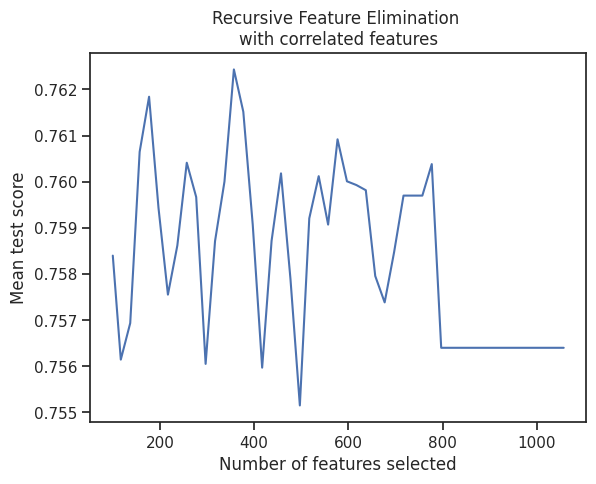

In [ ]:
cv_results = pd.DataFrame(selector_1.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
# plt.ylim(0, 1)
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
   #yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
selector_1.n_features_

357

In [ ]:
with open("selector_1.pickle", "wb") as fh:
  pickle.dump(selector_1, fh)

In [ ]:
with open(r"selector_1.pickle", "rb") as input_file:
  selector_1 = pickle.load(input_file)

#### **HuberRegressor**

In [ ]:
selector_2 = RFECV(HuberRegressor, step=20,
                 min_features_to_select=100,
                 cv=5,
                 verbose=4
                 )

selector_2.fit(input_3,output_3)

Fitting estimator with 1057 features.
Fitting estimator with 1037 features.
Fitting estimator with 1017 features.
Fitting estimator with 997 features.
Fitting estimator with 977 features.
Fitting estimator with 957 features.
Fitting estimator with 937 features.
Fitting estimator with 917 features.
Fitting estimator with 897 features.
Fitting estimator with 877 features.
Fitting estimator with 857 features.
Fitting estimator with 837 features.
Fitting estimator with 817 features.
Fitting estimator with 797 features.
Fitting estimator with 777 features.
Fitting estimator with 757 features.
Fitting estimator with 737 features.
Fitting estimator with 717 features.
Fitting estimator with 697 features.
Fitting estimator with 677 features.
Fitting estimator with 657 features.
Fitting estimator with 637 features.
Fitting estimator with 617 features.
Fitting estimator with 597 features.
Fitting estimator with 577 features.
Fitting estimator with 557 features.
Fitting estimator with 537 features

RFECV(cv=5, estimator=HuberRegressor(), min_features_to_select=100, step=20,
      verbose=4)

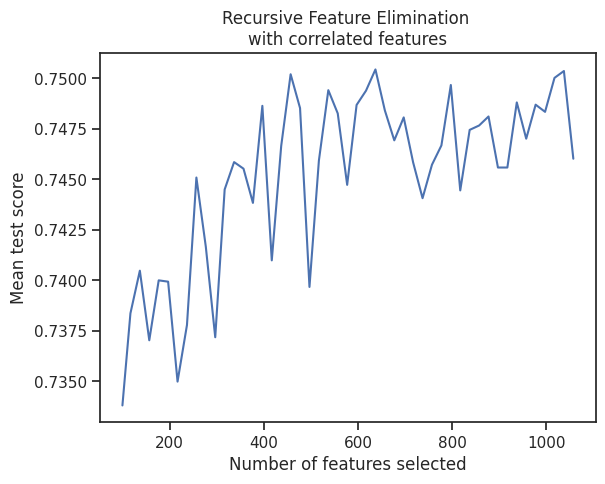

In [ ]:
cv_results = pd.DataFrame(selector_2.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
# plt.ylim(0, 1)
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
   #yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
selector_2.n_features_

637

In [ ]:
with open("selector_2.pickle", "wb") as fh:
  pickle.dump(selector_2, fh)

In [ ]:
with open(r"selector_2.pickle", "rb") as input_file:
  selector_3 = pickle.load(input_file)

#### **ExtraTreesRegressor**

In [38]:
selector_3 = RFECV(ExtraTreesRegressor, step=20,
                 min_features_to_select=100,
                 cv=5,
                 verbose=4
                 )

selector_3.fit(input_3,output_3)

Fitting estimator with 1057 features.


KeyboardInterrupt: 

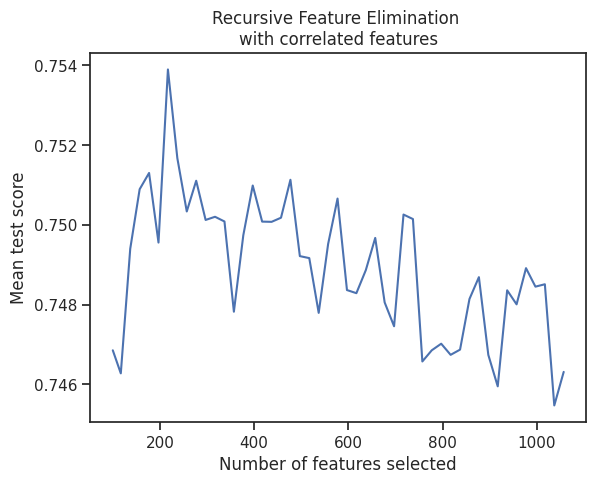

In [ ]:
cv_results = pd.DataFrame(selector_3.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
# plt.ylim(0, 1)
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
   #yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
selector_3.n_features_

217

In [ ]:
with open("selector_3.pickle", "wb") as fh:
  pickle.dump(selector_3, fh)

In [ ]:
with open(r"selector_3.pickle", "rb") as input_file:
  selector_3 = pickle.load(input_file)